In [40]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings

warnings.filterwarnings('ignore')

sns.set_theme()
sns.set_palette('deep')

### Load Data

In [3]:
# load the complete data
df2h = pd.read_parquet('outdata/datasets/complete/data2h.parquet')

no_num_cols = df2h.select_dtypes(exclude='number').columns.to_list()
no_miss_cols =  no_num_cols + ['hospital_expire_flag'] # list of all non-numeric columns + outcome

df2h['age'] = df2h['age'].factorize(sort=True)[0] # factorize the age so it can be used as a conditional variable


# all the imputation methods
imp_meth = ['None_ffillMedian','mice_2l.norm','mice_2l.pan','mice_norm','mice_pmm','mice_rf']
meth_labels = ['ffill','2l.norm','2l.pan','norm','pmm','rf']


imp_path = 'outdata/datasets/imputed/limdata/'
gt_path = 'outdata/datasets/missingtruth/'

files = os.listdir(imp_path)
datasets = os.listdir(gt_path)

colnames = ['package', 'method', 'miss_pattern', 'dataset', 'miss_rate', 'miss_type', 'weighting', 'sample']
df = pd.DataFrame([os.path.splitext(f)[0].split("_") for f in files], columns=colnames)
df['miss_rate'] = df['miss_rate'].astype(float)
df['files'] = [imp_path + f for f in files]


gb = df.groupby("package")
ffill = gb.get_group('None')
mice = gb.get_group('mice')





### Helper Functions

In [4]:
def split_mice(mice_df):
    # split the combined dataframe into one for each imputation
    n_imps = int(mice_df.columns[-1].split('.')[-1]) # how many imputations were done
    multiple_dfs = []
    for i in range(n_imps):
        s = '.' + str(i+1) +'$'
        tmp = mice_df.filter(regex=s)
        multiple_dfs.append(tmp)

    colnames = [os.path.splitext(col)[0] for col in multiple_dfs[0].columns] # remove df numbering
    colnames[-1] = colnames[-1][1:]  # remove x before dataset name
    for d in multiple_dfs:
        d.columns = colnames
        d.set_index(['subject_id', colnames[-1]], inplace=True)
        
        try:
            d = d.drop(no_miss_cols, axis=1, inplace=True)
        except:
            d = d.drop(no_num_cols, axis=1, inplace=True)

    return multiple_dfs

def mice_abs_error(mice_path, complete_df):
    try:
        complete_df = complete_df.drop(no_miss_cols, axis=1)
    except:
        complete_df = complete_df.drop(no_num_cols, axis=1)
    df_list = split_mice(pd.read_parquet(mice_path))
    errs = [mean_absolute_error(complete_df, imp_df) for imp_df in df_list]
    
    return errs


def mice_sqr_error(mice_path, complete_df):
    try:
        complete_df = complete_df.drop(no_miss_cols, axis=1)
    except:
        complete_df = complete_df.drop(no_num_cols, axis=1)
    df_list = split_mice(pd.read_parquet(mice_path))
    errs = [mean_squared_error(complete_df, imp_df) for imp_df in df_list]
    
    return errs





### Calculate Errors to the Complete Data

#### For the Mice methods:
here multiple data sets have to be extracted from the files and handled seperately because mice always produces multiple imputed dataframs 

In [4]:
# 10m42s
mice['mae'] = [mice_abs_error(imp, df2h) for imp in mice['files']]
mice['mse'] = [mice_sqr_error(imp, df2h) for imp in mice['files']]
mice['rmse'] = [np.sqrt(l) for l in mice['mse']]

# mice['mae_avg'] = mice['mae'].apply(np.mean)
# mice['mse_avg'] = mice['mse'].apply(np.mean)
# mice['rmse_avg'] = mice['rmse'].apply(np.mean)

#### For the Rest
for the other methods were only one imputed dataframe gets created the error calculations are more straight forward

In [5]:
# 26s
ffill['mae'] = [mean_absolute_error(df2h.drop(no_miss_cols, axis=1), pd.read_parquet(imp).drop(no_miss_cols, axis=1)) for imp in ffill['files']]
ffill['mse'] = [mean_squared_error(df2h.drop(no_miss_cols, axis=1), pd.read_parquet(imp).drop(no_miss_cols, axis=1)) for imp in ffill['files']]
ffill['rmse'] = [np.sqrt(l) for l in ffill['mse']]

# ffill['mae_avg'] = ffill['mae'].apply(np.mean)
# ffill['mse_avg'] = ffill['mse'].apply(np.mean)
# ffill['rmse_avg'] = ffill['rmse'].apply(np.mean)

#### Combine MICE and others

In [6]:
df = pd.concat([mice, ffill], axis=0).explode(['mae', 'mse', 'rmse'])


#### Save/Reload Data

In [7]:
# df.to_parquet('outdata/errs_to_complete_data_limdata.parquet')

In [4]:
df = pd.read_parquet('outdata/errs_to_complete_data_limdata.parquet')
df.shape

(7280, 12)

In [5]:
df = df[(df['weighting'] == 'equal') |( df['weighting'] == 'None')]
df.shape

(3120, 12)

#### Visualize

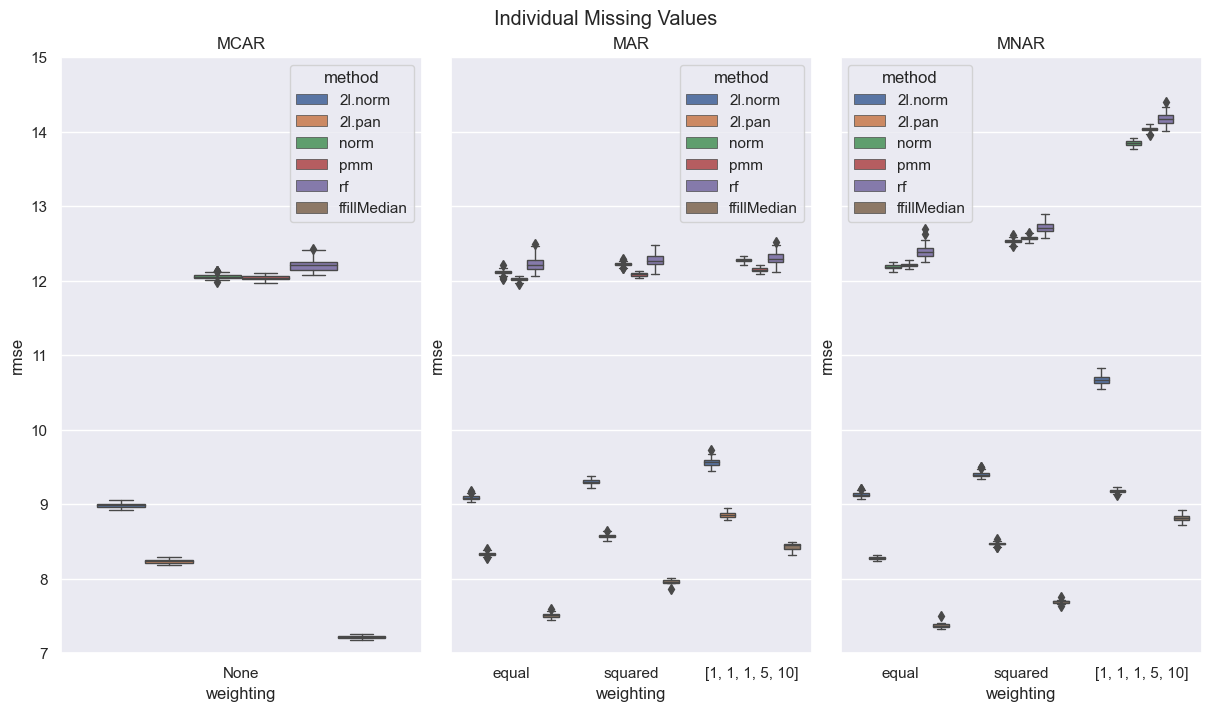

In [479]:
fig = plt.figure(constrained_layout=True, figsize=(12,7))

single = fig.subplots(1,3, sharex=False, sharey=True)

## mcar
sns.boxplot(ax=single[0], data=df[(df['miss_pattern']=='mcar') & (df['miss_type']=='single')], x='weighting', y='rmse', hue='method', linewidth=1)
## mar
sns.boxplot(ax=single[1], data=df[(df['miss_pattern']=='mar')  & (df['miss_type']=='single')], x='weighting', y='rmse', hue='method', linewidth=1)
## mnar
sns.boxplot(ax=single[2], data=df[(df['miss_pattern']=='mnar') & (df['miss_type']=='single')], x='weighting', y='rmse', hue='method', linewidth=1)

pat = ['MCAR','MAR','MNAR']

for p,t in zip(single,pat):
    p.set_title(t)
    p.set_ylim(7,15)

plt.suptitle('Individual Missing Values')

plt.show()

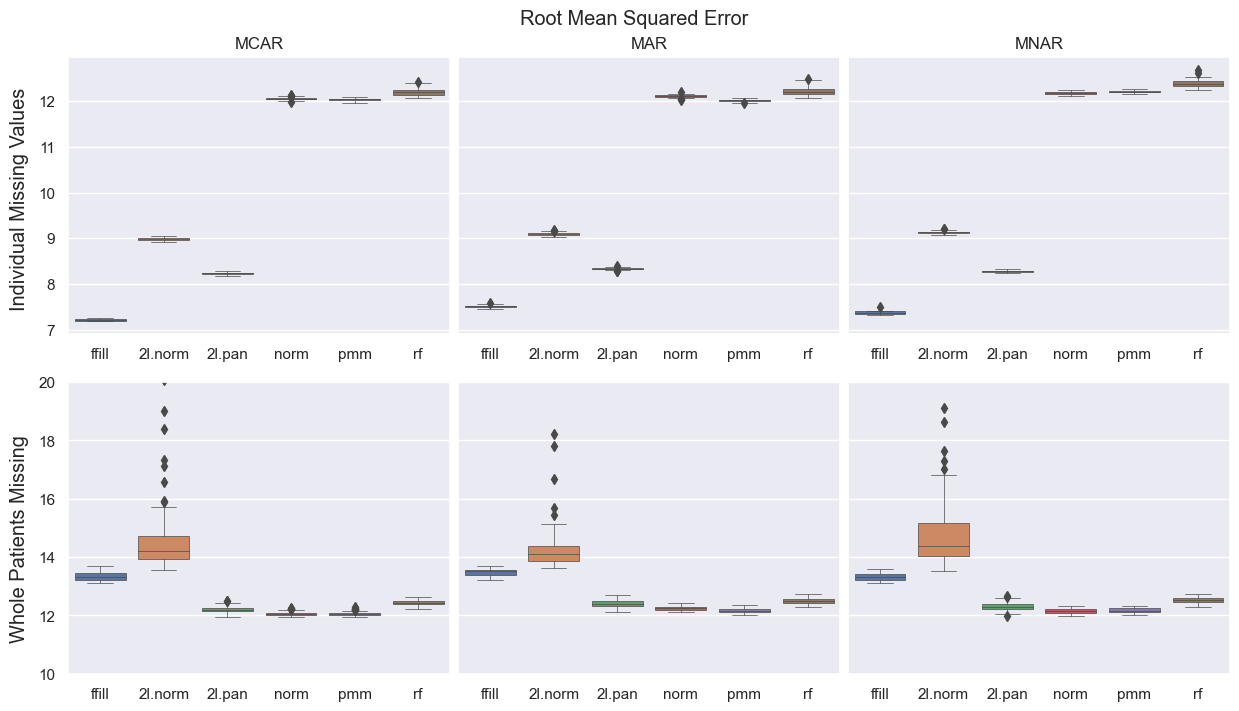

In [107]:
fig = plt.figure(constrained_layout=True, figsize=(12,7))

order = ['ffillMedian','2l.norm', '2l.pan', 'norm', 'pmm', 'rf']


subf = fig.subfigures(2,1)
single = subf[0].subplots(1,3, sharex=True, sharey=True)
patient = subf[1].subplots(1,3, sharex=True, sharey=True)

plt.suptitle('Root Mean Squared Error')
subf[0].suptitle('Individual Missing Values',x=-0.02, y=0.5, ha='left', va='center', rotation=90)
subf[1].suptitle('Whole Patients Missing',x=-0.02, y=0.5, ha='left', va='center', rotation=90)

## Single 
## mcar
# sns.stripplot(ax=single[0], data=df[(df['miss_pattern']=='mcar') & (df['miss_type']=='single')], x='method', y='rmse', hue='method', dodge=False, linewidth=0.5, order=order, marker='.', alpha=0.5)
sns.boxplot(ax=single[0], data=df[(df['miss_pattern']=='mcar') & (df['miss_type']=='single')], x='method', y='rmse', hue='method', dodge=False, linewidth=0.5, order=order, hue_order=order)

## mar
# sns.stripplot(ax=single[1], data=df[(df['miss_pattern']=='mar') & (df['miss_type']=='single')], x='method', y='rmse', hue='method', dodge=False, linewidth=0.5, order=order, marker='.', alpha=0.5)
sns.boxplot(ax=single[1], data=df[(df['miss_pattern']=='mar') & (df['miss_type']=='single')], x='method', y='rmse', hue='method', dodge=False, linewidth=0.5, order=order, hue_order=order)
## mnar
# sns.stripplot(ax=single[2], data=df[(df['miss_pattern']=='mnar') & (df['miss_type']=='single')], x='method', y='rmse', hue='method', dodge=False, linewidth=0.5, order=order, marker='.', alpha=0.5)
sns.boxplot(ax=single[2], data=df[(df['miss_pattern']=='mnar') & (df['miss_type']=='single')], x='method', y='rmse', hue='method', dodge=False, linewidth=0.5, order=order, hue_order=order)

## Patient
## mcar
# sns.stripplot(ax=patient[0], data=df[(df['miss_pattern']=='mcar') & (df['miss_type']=='patient')], x='method', y='rmse', hue='method', dodge=False, linewidth=0.5, order=order, marker='.', alpha=0.5)
sns.boxplot(ax=patient[0], data=df[(df['miss_pattern']=='mcar') & (df['miss_type']=='patient')], x='method', y='rmse', hue='method', dodge=False, linewidth=0.5, order=order, hue_order=order)
## mar
# sns.stripplot(ax=patient[1], data=df[(df['miss_pattern']=='mar') & (df['miss_type']=='patient')], x='method', y='rmse', hue='method', dodge=False, linewidth=0.5, order=order, marker='.', alpha=0.5)
sns.boxplot(ax=patient[1], data=df[(df['miss_pattern']=='mar') & (df['miss_type']=='patient')], x='method', y='rmse', hue='method', dodge=False, linewidth=0.5, order=order, hue_order=order)
## mnar
# sns.stripplot(ax=patient[2], data=df[(df['miss_pattern']=='mnar') & (df['miss_type']=='patient')], x='method', y='rmse', hue='method', dodge=False, linewidth=0.5, order=order, marker='.', alpha=0.5)
sns.boxplot(ax=patient[2], data=df[(df['miss_pattern']=='mnar') & (df['miss_type']=='patient')], x='method', y='rmse', hue='method', dodge=False, linewidth=0.5, order=order, hue_order=order)

pat = ['MCAR','MAR','MNAR']

for p,t in zip(single,pat):
    p.set_title(t)
    p.set_xlabel('')
    p.set_ylabel('')
    p.set_xticklabels(meth_labels)
    p.get_legend().remove()

for p,t in zip(patient,pat):
    p.set_xlabel('')
    p.set_ylabel('')
    p.set_xticklabels(meth_labels)
    p.set_ylim(10,20)
    p.get_legend().remove()



plt.savefig('outdata/images/rmse_boxonly.pdf', bbox_inches='tight') 
plt.show()

In [72]:
df.head()

,package,method,miss_pattern,dataset,miss_rate,miss_type,weighting,sample,files,mae,mse,rmse
0,mice,2l.norm,mar,2h,0.5,patient,equal,0,outdata/datasets/imputed/limdata/mice_2l.norm_...,6.739754,198.671779,14.095098
0,mice,2l.norm,mar,2h,0.5,patient,equal,0,outdata/datasets/imputed/limdata/mice_2l.norm_...,6.564651,187.290055,13.685396
0,mice,2l.norm,mar,2h,0.5,patient,equal,0,outdata/datasets/imputed/limdata/mice_2l.norm_...,6.620167,188.028987,13.712366
0,mice,2l.norm,mar,2h,0.5,patient,equal,0,outdata/datasets/imputed/limdata/mice_2l.norm_...,6.676482,197.228730,14.043815
0,mice,2l.norm,mar,2h,0.5,patient,equal,0,outdata/datasets/imputed/limdata/mice_2l.norm_...,6.760454,246.145809,15.689035


In [76]:
df.groupby(['method', 'miss_type','miss_pattern']).mean()

miss_rate       mae         mse       rmse
method      miss_type miss_pattern                                            
2l.norm     patient   mar                 0.5  6.697379  214.216110  14.511501
                      mcar                0.5  6.620187  233.022641  14.878634
                      mnar                0.5  6.731192  227.407527  14.958185
            single    mar                 0.5  4.222434   82.625816   9.089833
                      mcar                0.5  4.182377   80.743975   8.985725
                      mnar                0.5  4.284542   83.361034   9.130191
2l.pan      patient   mar                 0.5  6.060541  153.873316  12.403920
                      mcar                0.5  5.916906  149.045993  12.207980
                      mnar                0.5  6.019226  151.513958  12.308461
            single    mar                 0.5  4.049386   69.459991   8.334244
                      mcar                0.5  4.010537   67.754888   8.231310
                      mnar                0.5  4.064199   68.489869   8.275836
ffillMedian patient   mar                 0.5  6.549291  181.599412  13.475369
                      mcar                0.5  6.428657  178.346862  13.353577
                      mnar                0.5  6.486703  177.515399  13.322837
            single    mar                 0.5  3.262194   56.391882   7.509387
                      mcar                0.5  3.138871   52.106461   7.218434
                      mnar                0.5  3.253975   54.337543   7.371302
norm        patient   mar                 0.5  5.983811  150.111101  12.251772
                      mcar                0.5  5.847399  145.625507  12.067378
                      mnar                0.5  5.943541  147.761785  12.155456
            single    mar                 0.5  5.872670  146.795695  12.115895
                      mcar                0.5  5.848030  145.353299  12.056226
                      mnar                0.5  5.933597  148.450248  12.183987
pmm         patient   mar                 0.5  5.895317  147.952602  12.163354
                      mcar                0.5  5.791114  145.278082  12.052958
                      mnar                0.5  5.916483  148.164370  12.171983
            single    mar                 0.5  5.781686  144.449377  12.018686
                      mcar                0.5  5.788917  144.965264  12.040128
                      mnar                0.5  5.919039  149.123963  12.211607
rf          patient   mar                 0.5  6.033389  156.542544  12.511353
                      mcar                0.5  5.950515  154.685536  12.436987
                      mnar                0.5  6.067932  157.201100  12.537635
            single    mar                 0.5  5.828844  149.460369  12.225071
                      mcar                0.5  5.822967  149.092041  12.210073
                      mnar                0.5  5.955491  153.426765  12.386310

### Characteristics of Complete/Imputed Datasets

In [21]:
# Complete dataset:
df2h.describe().loc[['mean', 'std']]

,heart_rate,systolic_blood_pressure,diastolic_blood_pressure,respiratory_rate,oxygen_saturation,age,hospital_expire_flag
mean,84.422677,123.344118,62.190402,18.930631,96.818442,2.287542,0.041207
std,16.188632,20.397514,13.341383,4.906851,2.588960,0.926257,0.198771


In [22]:
meancols = [var + "_mean" for var in df2h.drop(no_miss_cols, axis=1).columns]
stdcols = [var + "_std" for var in df2h.drop(no_miss_cols, axis=1).columns]

#### MICE

In [23]:
# helper funs 
def mice_mean(mice_path):
    # a little weird this calculates the average mean for each column over all m mice imputated data frames
    df_list = split_mice(pd.read_parquet(mice_path))
    
    return np.mean([np.array(df.mean()) for df in df_list], axis=0)

def mice_std(mice_path):
    # a little weird this calculates the average std for each column over all m mice imputated data frames
    df_list = split_mice(pd.read_parquet(mice_path))
    
    return np.mean([np.array(df.std()) for df in df_list], axis=0)

In [24]:
miceImp = gb.get_group('mice')
miceImp[meancols] = [mice_mean(imp) for imp in miceImp['files']]
miceImp[stdcols] = [mice_std(imp) for imp in miceImp['files']]

KeyboardInterrupt: 

In [ ]:
miceImp.shape

(1400, 19)

#### Non-MICE

In [ ]:
singleImp = gb.get_group('None')
singleImp[meancols] = [list(pd.read_parquet(imp).drop(no_miss_cols, axis=1).mean()) for imp in singleImp['files']]
singleImp[stdcols] = [list(pd.read_parquet(imp).drop(no_miss_cols, axis=1).std()) for imp in singleImp['files']]
# singleImp[stdcols] = [pd.read_parquet(imp).drop(no_miss_cols, axis=1).std() for imp in singleImp['files']]

In [18]:
singleImp.shape

(280, 19)

#### Combining Mice & Non Mice imputations

In [ ]:
impmeanstd = pd.concat([miceImp, singleImp], axis=0)

In [ ]:
impmeanstd = pd.DataFrame(impmeanstd.groupby(['method','miss_pattern','miss_type','weighting']).mean()).drop('miss_rate', axis=1).reset_index()

In [21]:
impmeanstd.head()

,method,miss_pattern,miss_type,weighting,heart_rate_mean,systolic_blood_pressure_mean,diastolic_blood_pressure_mean,respiratory_rate_mean,oxygen_saturation_mean,heart_rate_std,systolic_blood_pressure_std,diastolic_blood_pressure_std,respiratory_rate_std,oxygen_saturation_std
0,2l.norm,mar,patient,"[1, 1, 1, 5, 10]",85.155877,122.406543,64.349868,18.544871,96.876532,18.158064,20.376383,13.425341,5.048234,2.829061
1,2l.norm,mar,patient,equal,84.754516,122.687180,63.365521,18.637664,96.915524,20.013869,20.296845,13.620827,4.991699,2.831493
2,2l.norm,mar,patient,squared,85.274314,122.529547,64.232107,18.581844,96.922953,18.697936,20.273492,13.572316,5.047738,2.913315
3,2l.norm,mar,single,"[1, 1, 1, 5, 10]",84.573119,123.111036,62.442734,18.844630,96.868665,16.365331,20.371483,13.369882,4.943944,2.581903
4,2l.norm,mar,single,equal,84.420666,123.234238,62.216058,18.889342,96.858586,16.294789,20.428243,13.376090,4.914168,2.581882


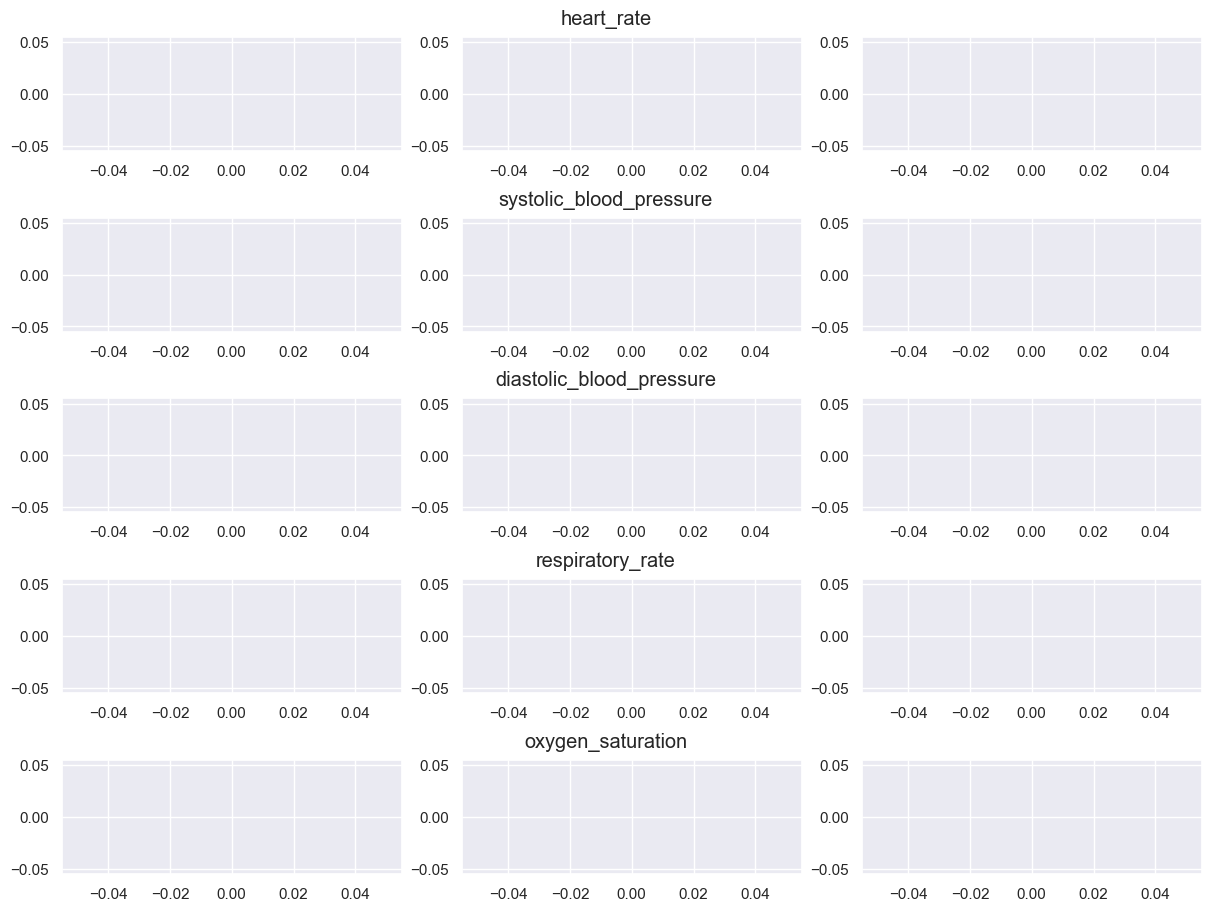

In [34]:
fig = plt.figure(constrained_layout=True, figsize=(12,9))


subf = fig.subfigures(5,1)
vars = ['heart_rate', 'systolic_blood_pressure', 'diastolic_blood_pressure', 'respiratory_rate', 'oxygen_saturation']

for f, var in zip(subf, vars):
    single = f.subplots(1,3, sharex=False, sharey=False)
    
    ## mcar
    single[0].errorbar(data=impmeanstd[(impmeanstd['miss_pattern']=='mcar') & (impmeanstd['miss_type']=='both') ], x='method', y=var + '_mean', yerr=var + '_std',fmt='o')
    ## mar
    single[1].errorbar(data=impmeanstd[(impmeanstd['miss_pattern']=='mar')  & (impmeanstd['miss_type']=='both') & (impmeanstd['weighting']=='equal')], x='method', y=var + '_mean', yerr=var + '_std',fmt='o')
    ## mnar
    single[2].errorbar(data=impmeanstd[(impmeanstd['miss_pattern']=='mnar') & (impmeanstd['miss_type']=='both') & (impmeanstd['weighting']=='equal')], x='method', y=var + '_mean', yerr=var + '_std',fmt='o')

    pat = ['MCAR','MAR','MNAR']

    mean = df2h[var].mean()
    std = df2h[var].std()

    # for p,t in zip(subp,pat):
    #     p.set_title(t)
    #     p.axhline(y=mean, color='r', linestyle='-')
    #     p.axhline(y=mean +std , color='r', linestyle='--')
    #     p.axhline(y=mean -std, color='r', linestyle='--')
    
    f.suptitle(var)



plt.show()

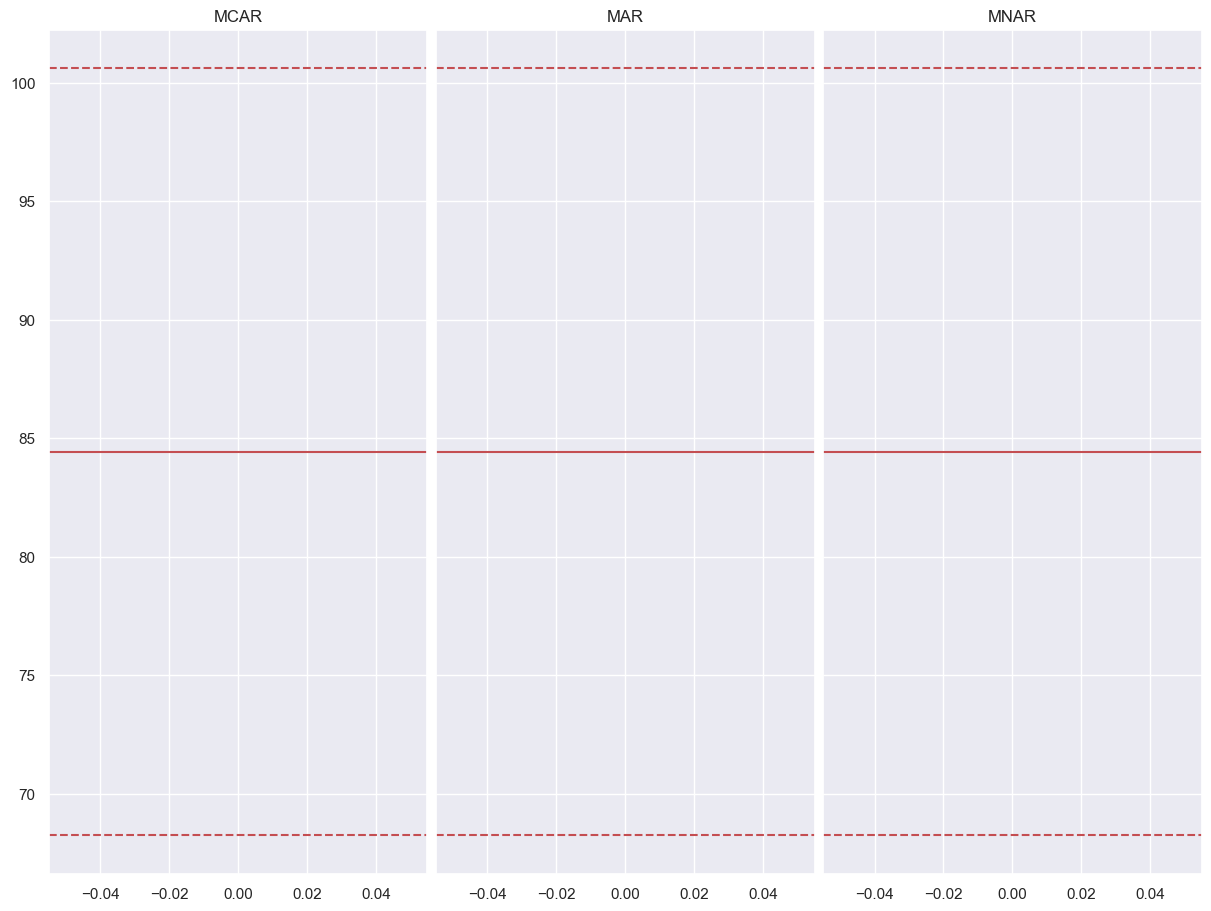

In [23]:

fig = plt.figure(constrained_layout=True, figsize=(12,9))
#  ['heart_rate', 'systolic_blood_pressure', 'diastolic_blood_pressure', 'respiratory_rate', 'oxygen_saturation']

single = fig.subplots(1,3, sharex=False, sharey=True)
var = 'heart_rate'


## mcar
single[0].errorbar(data=impmeanstd[(impmeanstd['miss_pattern']=='mcar') & (impmeanstd['miss_type']=='both') ], x='method', y=var + '_mean', yerr=var + '_std',fmt='o')
## mar
single[1].errorbar(data=impmeanstd[(impmeanstd['miss_pattern']=='mar')  & (impmeanstd['miss_type']=='both') & (impmeanstd['weighting']=='equal')], x='method', y=var + '_mean', yerr=var + '_std',fmt='o')
## mnar
single[2].errorbar(data=impmeanstd[(impmeanstd['miss_pattern']=='mnar') & (impmeanstd['miss_type']=='both') & (impmeanstd['weighting']=='equal')], x='method', y=var + '_mean', yerr=var + '_std',fmt='o')

pat = ['MCAR','MAR','MNAR']

mean = df2h[var].mean()
std = df2h[var].std()

for p,t in zip(single,pat):
    p.set_title(t)
    p.axhline(y=mean, color='r', linestyle='-')
    p.axhline(y=mean +std , color='r', linestyle='--')
    p.axhline(y=mean -std, color='r', linestyle='--')


plt.show()

### Comparing imputed values to ground truth

In [25]:

# example = 'mar_2h_0.5_single_equal_0.parquet'
example = 'mcar_2h_0.5_patient_None_0.parquet'
# add ground truth and ffill
gt_vals = pd.read_parquet(gt_path + example).reset_index(drop=True).drop(no_miss_cols, axis=1)
gt_vals['meth'] = 'Ground_Truth'
imp_vals =  pd.read_parquet(imp_path + imp_meth[0] + "_" + example).where(gt_vals.notna()).drop(no_miss_cols, axis=1)# .add_prefix(imp_meth[0]+ "_")
imp_vals['meth'] = imp_meth[0]
nomiss_vals = df2h.reset_index(drop=True).drop(no_miss_cols, axis=1).where(gt_vals.isna())
nomiss_vals['meth'] = 'Non_Missing'

vals = pd.concat([gt_vals, nomiss_vals, imp_vals])

In [26]:
stubs = ['heart_rate.', 'systolic_blood_pressure.',
       'diastolic_blood_pressure.', 'respiratory_rate.',
       'oxygen_saturation.', 'age.', 'gender.', 'admission_type.',
       'first_careunit.', 'subject_id.', 'x2h.',]

print(vals.shape)

# for the mice methods:
for meth in imp_meth[1:]:
   imp_vals = pd.read_parquet(imp_path + meth + "_" + example)
   imp_vals['id'] = imp_vals.index
   imp_vals = pd.wide_to_long(df = imp_vals, stubnames = stubs, i = "id", j = "miSet").drop(['age.', 'gender.', 'admission_type.', 'hospital_expire_flag.1', 'hospital_expire_flag.2', 'hospital_expire_flag.3', 'hospital_expire_flag.4', 'hospital_expire_flag.5', 'first_careunit.', 'subject_id.', 'x2h.'], axis=1, errors='ignore')
   imp_vals.columns = imp_vals.columns.str.strip('.')
   imp_vals['meth'] = meth
   vals = pd.concat([vals, imp_vals])
   print(meth + " done")
   print(vals.shape)

(260706, 6)
mice_2l.norm done
(695216, 6)
mice_2l.pan done
(1129726, 6)


KeyboardInterrupt: 

### Do it for (one sample of) all variants

In [108]:
dropcols = [
    'age.', 'gender.', 'admission_type.', 'hospital_expire_flag.1', 
    'hospital_expire_flag.2', 'hospital_expire_flag.3', 'hospital_expire_flag.4', 
    'hospital_expire_flag.5', 'first_careunit.', 'subject_id.', 'x2h.','heart rate', 'systolic blood pressure',
    'diastolic blood pressure', 'respiratory rate', 'oxygen saturation',
    ]

stubs = [
    'heart_rate.', 'systolic_blood_pressure.',
    'diastolic_blood_pressure.', 'respiratory_rate.',
    'oxygen_saturation.', 'age.', 'gender.', 'admission_type.',
    'first_careunit.', 'subject_id.', 'x2h.',
    ]

dfs = []
currsample = "0"


for dataset in datasets:
    parts = dataset.split("_")
    if parts[-1] != currsample + ".parquet":
        continue
    sample = parts[-1].split(".")[0]
    if parts[-2] != "equal" and parts[-2] != "None":
        continue
    
    print(dataset, end=" ")
    

    gt_vals = pd.read_parquet(gt_path + dataset).reset_index(drop=True).drop(no_miss_cols, axis=1)
    gt_vals['meth'] = 'Ground_Truth'
    gt_vals['misshypo'] = parts[0]
    gt_vals['misstype'] = parts[3]
    gt_vals['weighting'] = parts[4]
    gt_vals['sample'] = sample
    dfs.append(gt_vals)
    print("|", end="")


    nomiss_vals = df2h.reset_index(drop=True).drop(no_miss_cols, axis=1).where(gt_vals.isna())
    nomiss_vals['meth'] = 'Non_Missing'
    nomiss_vals['misshypo'] = parts[0]
    nomiss_vals['misstype'] = parts[3]
    nomiss_vals['weighting'] = parts[4]
    nomiss_vals['sample'] = sample
    dfs.append(nomiss_vals)
    print("|", end="")

    imp_vals =  pd.read_parquet(imp_path + imp_meth[0] + "_" + dataset).drop(no_miss_cols, axis=1)# .add_prefix(imp_meth[0]+ "_") 
    imp_vals['meth'] = imp_meth[0]
    imp_vals['misshypo'] = parts[0]
    imp_vals['misstype'] = parts[3]
    imp_vals['weighting'] = parts[4]
    imp_vals['sample'] = sample
    dfs.append(imp_vals)
    print("|", end="")

    # MICE
    for meth in imp_meth[1:]:
        # print("  " + meth)
        imp_vals = pd.read_parquet(imp_path + meth + "_" + dataset)
        imp_vals['id'] = imp_vals.index
        imp_vals = pd.wide_to_long(df = imp_vals, stubnames = stubs, i = "id", j = "miSet").drop(dropcols, axis=1, errors='ignore')
        imp_vals.columns = imp_vals.columns.str.strip('.')
        imp_vals['meth'] = meth
        imp_vals['misshypo'] = parts[0]
        imp_vals['misstype'] = parts[3]
        imp_vals['weighting'] = parts[4]
        imp_vals['sample'] = sample
        dfs.append(imp_vals)
        print("|", end="")

    print("")

comparedfs = pd.concat(dfs)
# comparedfs.to_pickle("outdata/comparedf"+currsample+".pkl")
    



mar_2h_0.5_patient_equal_1.parquet ||||||||
mar_2h_0.5_single_equal_1.parquet ||||||||
mcar_2h_0.5_patient_None_1.parquet ||||||||
mcar_2h_0.5_single_None_1.parquet ||||||||
mnar_2h_0.5_patient_equal_1.parquet ||||||||
mnar_2h_0.5_single_equal_1.parquet ||||||||


In [5]:
comparedfs = pd.read_pickle("outdata/comparedf0.pkl")

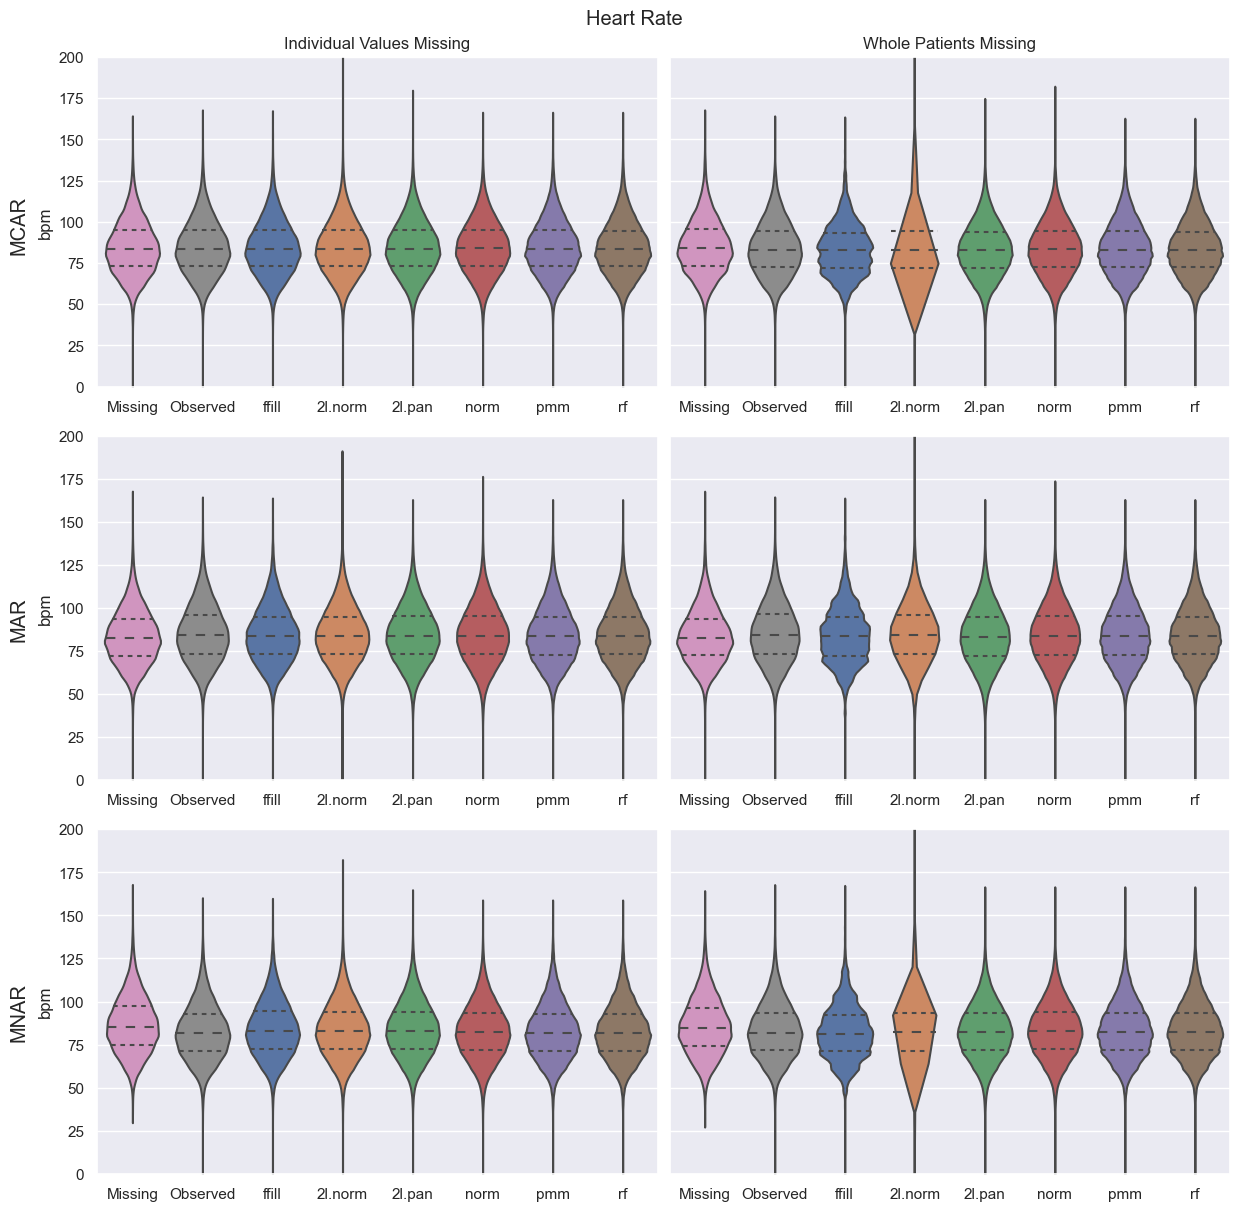

In [109]:

fig = plt.figure(constrained_layout=True, figsize=(12,12))

featno = 0

ylabs = ['Missing', 'Observed'] + meth_labels
order = ['ffillMedian','2l.norm', '2l.pan', 'norm', 'pmm', 'rf']
feats = ['heart_rate', 'systolic_blood_pressure', 'diastolic_blood_pressure', 'respiratory_rate', 'oxygen_saturation']
titles = ['Heart Rate', 'Systolic Blood Pressure', 'Diastolic Blood Pressure', 'Respiratory Rate', 'Oxygen Saturation']
units = ['bpm', 'mmHg', 'mmHg', 'bpm', '%']
ranges = [(0,200), (0,250),(0,200), (0,60),(85,110)]

feat = feats[featno]
title = titles[featno]
unit = units[featno]
yrange = ranges[featno]

pal = sns.color_palette()
newpal = pal[6:8] + pal[:6]

subf = fig.subfigures(3,1)
mcar = subf[0].subplots(1,2, sharex=True, sharey=True)
mar = subf[1].subplots(1,2, sharex=True, sharey=True)
mnar = subf[2].subplots(1,2, sharex=True, sharey=True)

plt.suptitle(title)
subf[0].suptitle('MCAR',x=-0.02, y=0.5, ha='left', va='center', rotation=90)
subf[1].suptitle('MAR',x=-0.02, y=0.5, ha='left', va='center', rotation=90)
subf[2].suptitle('MNAR',x=-0.02, y=0.5, ha='left', va='center', rotation=90)


sns.violinplot(comparedfs[(comparedfs['misshypo']=='mcar') & (comparedfs['misstype']=='single')] ,ax=mcar[0], x='meth', y=feat, inner='quartiles', palette=newpal)
sns.violinplot(comparedfs[(comparedfs['misshypo']=='mcar') & (comparedfs['misstype']=='patient')] ,ax=mcar[1], x='meth', y=feat, inner='quartiles', palette=newpal)

sns.violinplot(comparedfs[(comparedfs['misshypo']=='mar') & (comparedfs['misstype']=='single')] ,ax=mar[0], x='meth', y=feat, inner='quartiles', palette=newpal)
sns.violinplot(comparedfs[(comparedfs['misshypo']=='mar') & (comparedfs['misstype']=='patient')] ,ax=mar[1], x='meth', y=feat, inner='quartiles', palette=newpal)

sns.violinplot(comparedfs[(comparedfs['misshypo']=='mnar') & (comparedfs['misstype']=='single')] ,ax=mnar[0], x='meth', y=feat, inner='quartiles', palette=newpal)
sns.violinplot(comparedfs[(comparedfs['misshypo']=='mnar') & (comparedfs['misstype']=='patient')] ,ax=mnar[1], x='meth', y=feat, inner='quartiles', palette=newpal)


pat = ['Individual Values Missing', 'Whole Patients Missing']

for p,t in zip(mcar,pat):
    p.set_title(t)
    p.set_xlabel('')
    p.set_ylabel('')
    p.set_xticklabels(ylabs)
    p.set_ylim(yrange)


for p,t in zip(mar,pat):
    p.set_xlabel('')
    p.set_ylabel('')
    p.set_xticklabels(ylabs)
    p.set_ylim(yrange)

for p,t in zip(mnar,pat):
    p.set_xlabel('')
    p.set_ylabel('')
    p.set_xticklabels(ylabs)
    p.set_ylim(yrange)

mcar[0].set_ylabel(unit)
mar[0].set_ylabel(unit)
mnar[0].set_ylabel(unit)


# plt.savefig('outdata/images/distribution/'+feat+'.pdf', bbox_inches='tight') 
plt.show()

In [62]:
comparedfs[(comparedfs['misshypo']=='mnar') & (comparedfs['misstype']=='patient') & (comparedfs['meth']=='mice_2l.norm')].describe().round(2)

,heart_rate,systolic_blood_pressure,diastolic_blood_pressure,respiratory_rate,oxygen_saturation
count,434510.00,434510.00,434510.00,434510.00,434510.00
mean,82.68,121.76,61.13,18.49,96.95
std,22.28,20.20,13.26,4.76,2.98
min,-2531.81,-72.01,-91.74,-24.40,-60.86
25%,71.57,107.60,52.10,15.30,95.56
50%,82.10,120.87,60.60,18.23,97.10
75%,93.34,135.10,69.45,21.48,98.60
max,1974.87,327.31,170.17,77.10,211.42


In [58]:
comparedfs[(comparedfs['misstype']=='single') & (comparedfs['meth']=='mice_2l.norm')].describe()

,heart_rate,systolic_blood_pressure,diastolic_blood_pressure,respiratory_rate,oxygen_saturation
count,1.303530e+06,1.303530e+06,1.303530e+06,1.303530e+06,1.303530e+06
mean,8.415963e+01,1.229526e+02,6.190592e+01,1.875303e+01,9.687406e+01
std,1.623942e+01,2.038567e+01,1.326664e+01,4.850543e+00,2.628783e+00
min,-7.360484e+01,-3.470668e+01,-2.958020e+01,-5.402323e+01,8.000000e+00
25%,7.280919e+01,1.081000e+02,5.284591e+01,1.550000e+01,9.549871e+01
50%,8.344575e+01,1.215000e+02,6.100000e+01,1.850000e+01,9.704884e+01
75%,9.466667e+01,1.363784e+02,7.010000e+01,2.166667e+01,9.860000e+01
max,2.049848e+02,2.528601e+02,1.685615e+02,9.900000e+01,1.880953e+02


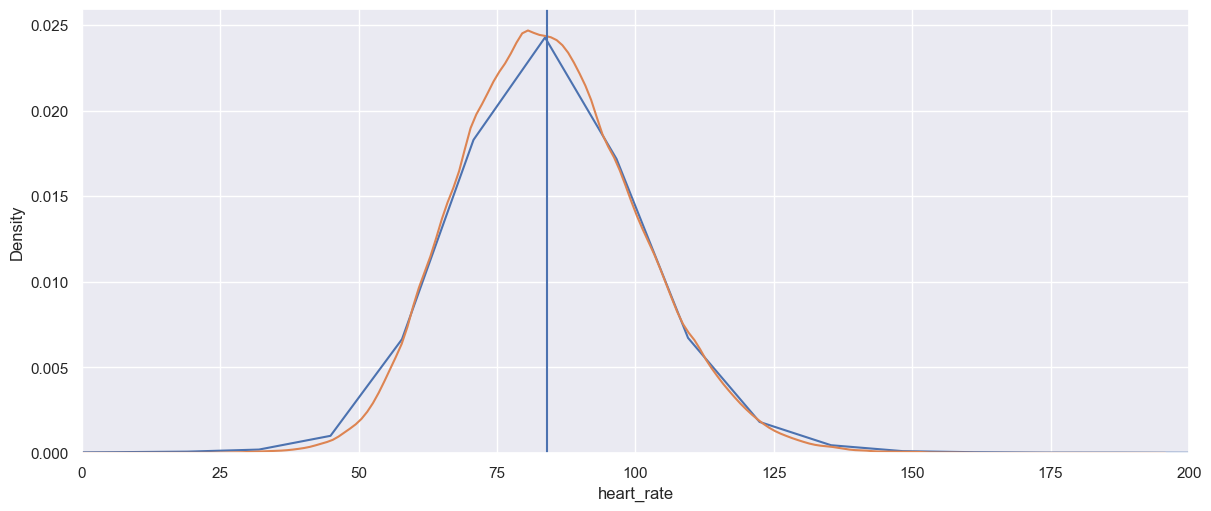

In [38]:
# ffill distribution
fig = plt.figure(constrained_layout=True, figsize=(12,5))

featno = 0

ylabs = ['Missing', 'Observed'] + meth_labels
order = ['ffillMedian','2l.norm', '2l.pan', 'norm', 'pmm', 'rf']
feats = ['heart_rate', 'systolic_blood_pressure', 'diastolic_blood_pressure', 'respiratory_rate', 'oxygen_saturation']
titles = ['Heart Rate', 'Systolic Blood Pressure', 'Diastolic Blood Pressure', 'Respiratory Rate', 'Oxygen Saturation']
units = ['bpm', 'mmHg', 'mmHg', 'bpm', '%']
ranges = [(0,200), (0,250),(0,200), (0,60),(85,110)]

feat = feats[featno]
title = titles[featno]
unit = units[featno]
yrange = ranges[featno]

# pal = sns.color_palette()
# newpal = pal[6:8] + pal[:6]

# subf = fig.subfigures(3,1)
# mcar = subf[0].subplots(1,2, sharex=True, sharey=True)
# mar = subf[1].subplots(1,2, sharex=True, sharey=True)
# mnar = subf[2].subplots(1,2, sharex=True, sharey=True)

# plt.suptitle(title)
# subf[0].suptitle('MCAR',x=-0.02, y=0.5, ha='left', va='center', rotation=90)
# subf[1].suptitle('MAR',x=-0.02, y=0.5, ha='left', va='center', rotation=90)
# subf[2].suptitle('MNAR',x=-0.02, y=0.5, ha='left', va='center', rotation=90)


sns.kdeplot(comparedfs[(comparedfs['misshypo']=='mcar') & (comparedfs['misstype']=='patient') & (comparedfs['meth']=='mice_2l.norm')], x=feat, )
sns.kdeplot(comparedfs[(comparedfs['misshypo']=='mcar') & (comparedfs['misstype']=='single') & (comparedfs['meth']=='mice_2l.norm')], x=feat, )
# sns.kdeplot(comparedfs[(comparedfs['misshypo']=='mcar') & (comparedfs['misstype']=='patient') & (comparedfs['meth']=='Ground_Truth')], x=feat, )

med = comparedfs[(comparedfs['misshypo']=='mcar') & (comparedfs['misstype']=='patient') & (comparedfs['meth']=='Non_Missing')][feat].median()
plt.axvline(med)
plt.xlim(yrange)

# pat = ['Individual Values Missing', 'Whole Patients Missing']

# for p,t in zip(mcar,pat):
#     p.set_title(t)
#     p.set_xlabel('')
#     p.set_ylabel('')
#     p.set_xticklabels(ylabs)
#     p.set_ylim(yrange)

plt.show()

## Van Buuren Evaluation Criteria

1. Raw Bias RB EV(Imputation) - Ground Truth (Percent Bias PB (EV(Imputation) - Ground TruthValue)/Ground Truth Value)
2. Coverage Rate CR Proportion of Conf Intervals that contain GT Value
3. Average Width AW of Confidence Intervals

In [6]:
def mice_pool_mean_se(mice_path):
    # calculate the pooled mean and standard error of one set of multiple imputations according to rubins rules
    df_list = split_mice(pd.read_parquet(mice_path)) # list containing all completed datasets
    impmean = [np.array(df.mean()) for df in df_list]
    impse = [np.array(df.std(ddof=1)/np.sqrt(df.size)) for df in df_list]

    # pool according to rubins rules see here: https://bookdown.org/mwheymans/bookmi/rubins-rules.html
    # for mean pooling just means the average
    pooledmean = np.mean(impmean, axis=0)

    # for std error/ variance within and between imputation variance is taken into account
    varwithin = np.mean(np.square(impse), axis=0)
    varbetween = np.sum([np.square(singlemean - pooledmean) for singlemean in impmean], axis=0)/(len(df_list) - 1)
    pooledse = np.sqrt(varwithin + varbetween + (varbetween/len(df_list)))


    return pooledmean, pooledse


In [7]:
gb = df.groupby("package")
ffill = gb.get_group('None')
ffill['method'] = ffill['package'] + "_" + ffill['method']
ffill = ffill.drop(ffill[(ffill['weighting'] == 'squared') | (ffill['weighting'] == '[1, 1, 1, 5, 10]')].index )
ffill = ffill.drop(['weighting', 'dataset', 'miss_rate', 'package'], axis=1)

mice = gb.get_group('mice')
mice['method'] = mice['package'] + "_" + mice['method']
mice = mice.drop(mice[(mice['weighting'] == 'squared') | (mice['weighting'] == '[1, 1, 1, 5, 10]')].index )
mice = mice.drop(['weighting', 'dataset', 'miss_rate', 'package'], axis=1)

In [8]:
mice[['mean', 'se']] = [mice_pool_mean_se(imp) for imp in mice['files']]

In [9]:
mice['mean_hr'], mice['mean_sbp'], mice['mean_dbp'], mice['mean_rr'], mice['mean_ox'] = zip(*list(mice['mean'].values))
mice['se_hr'], mice['se_sbp'], mice['se_dbp'], mice['se_rr'], mice['se_ox'] = zip(*list(mice['se'].values))

mice = mice.drop(['files', 'mean', 'se'], axis=1)


In [10]:
ffill['mean'] = [np.array(np.mean(pd.read_parquet(sample)))[:5] for sample in ffill['files']]
ffill['mean_hr'], ffill['mean_sbp'], ffill['mean_dbp'], ffill['mean_rr'], ffill['mean_ox'] = zip(*list(ffill['mean'].values))
ffill['se'] = [np.array(pd.read_parquet(sample).std(ddof=1)/np.sqrt(pd.read_parquet(sample).size) )[:5] for sample in ffill['files']]
ffill['se_hr'], ffill['se_sbp'], ffill['se_dbp'], ffill['se_rr'], ffill['se_ox'] = zip(*list(ffill['se'].values))

ffill = ffill.drop(['files', 'mean', 'se'], axis=1)


In [11]:
evaldf = pd.concat([mice, ffill], axis=0)

### Calculate eval criteria from mean and se

In [15]:
# Ground truth
gt_mean = np.array(df2h.mean()[:5])


In [16]:
# Coverage Rate
evaldf['cov_hr'] = ((evaldf['mean_hr'] - (1.96 * evaldf['se_hr']) < gt_mean[0]) & (evaldf['mean_hr'] + (1.96 * evaldf['se_hr']) > gt_mean[0]))*1
evaldf['cov_sbp'] = ((evaldf['mean_sbp'] - (1.96 * evaldf['se_sbp']) < gt_mean[1]) & (evaldf['mean_sbp'] + (1.96 * evaldf['se_sbp']) > gt_mean[1]))*1
evaldf['cov_dbp'] = ((evaldf['mean_dbp'] - (1.96 * evaldf['se_dbp']) < gt_mean[2]) & (evaldf['mean_dbp'] + (1.96 * evaldf['se_dbp']) > gt_mean[2]))*1
evaldf['cov_rr'] = ((evaldf['mean_rr'] - (1.96 * evaldf['se_rr']) < gt_mean[3]) & (evaldf['mean_rr'] + (1.96 * evaldf['se_rr']) > gt_mean[3]))*1
evaldf['cov_ox'] = ((evaldf['mean_ox'] - (1.96 * evaldf['se_ox']) < gt_mean[4]) & (evaldf['mean_ox'] + (1.96 * evaldf['se_ox']) > gt_mean[4]))*1


eval_gb = evaldf.groupby(['method', 'miss_pattern', 'miss_type']).mean()

# Raw Bias
eval_gb['bias_hr'] = eval_gb['mean_hr'] - gt_mean[0]
eval_gb['bias_sbp'] = eval_gb['mean_sbp'] - gt_mean[1]
eval_gb['bias_dbp'] = eval_gb['mean_dbp'] - gt_mean[2]
eval_gb['bias_rr'] = eval_gb['mean_rr'] - gt_mean[3]
eval_gb['bias_ox'] = eval_gb['mean_ox'] - gt_mean[4]

# Percent Bias
eval_gb['perc_bias_hr'] = eval_gb['bias_hr'] / gt_mean[0] *100
eval_gb['perc_bias_sbp'] = eval_gb['bias_sbp'] / gt_mean[1] *100
eval_gb['perc_bias_dbp'] = eval_gb['bias_dbp'] / gt_mean[2] *100
eval_gb['perc_bias_rr'] = eval_gb['bias_rr'] / gt_mean[3] *100
eval_gb['perc_bias_ox'] = eval_gb['bias_ox'] / gt_mean[4] *100

# Average Width
#  since 95% conf interval is just mean +- 1.96SE the average width is just 2x 1.96SE
eval_gb['aw_hr'] = eval_gb['se_hr'] * 2 * 1.96
eval_gb['aw_sbp'] = eval_gb['se_sbp'] * 2 * 1.96
eval_gb['aw_dbp'] = eval_gb['se_dbp'] * 2 * 1.96
eval_gb['aw_rr'] = eval_gb['se_rr'] * 2 * 1.96
eval_gb['aw_ox'] = eval_gb['se_ox'] * 2 * 1.96


eval_gb = eval_gb.drop(['mean_hr', 'mean_sbp', 'mean_dbp', 'mean_rr', 'mean_ox', 'se_hr', 'se_sbp', 'se_dbp', 'se_rr', 'se_ox'], axis=1)
colorder = ['perc_bias_hr', 'cov_hr', 'aw_hr', 'bias_hr', 'perc_bias_sbp', 'cov_sbp', 'aw_sbp', 'bias_sbp', 'perc_bias_dbp', 'cov_dbp', 'aw_dbp', 'bias_dbp', 'perc_bias_rr', 'cov_rr', 'aw_rr', 'bias_rr', 'perc_bias_ox', 'cov_ox', 'aw_ox', 'bias_ox']
eval_gb = eval_gb[colorder]
evaldf = eval_gb.reset_index()

In [17]:
# evaldf.to_pickle("outdata/evalcritdf.pkl")
evaldf = pd.read_pickle("outdata/evalcritdf.pkl")

### Percent Bias

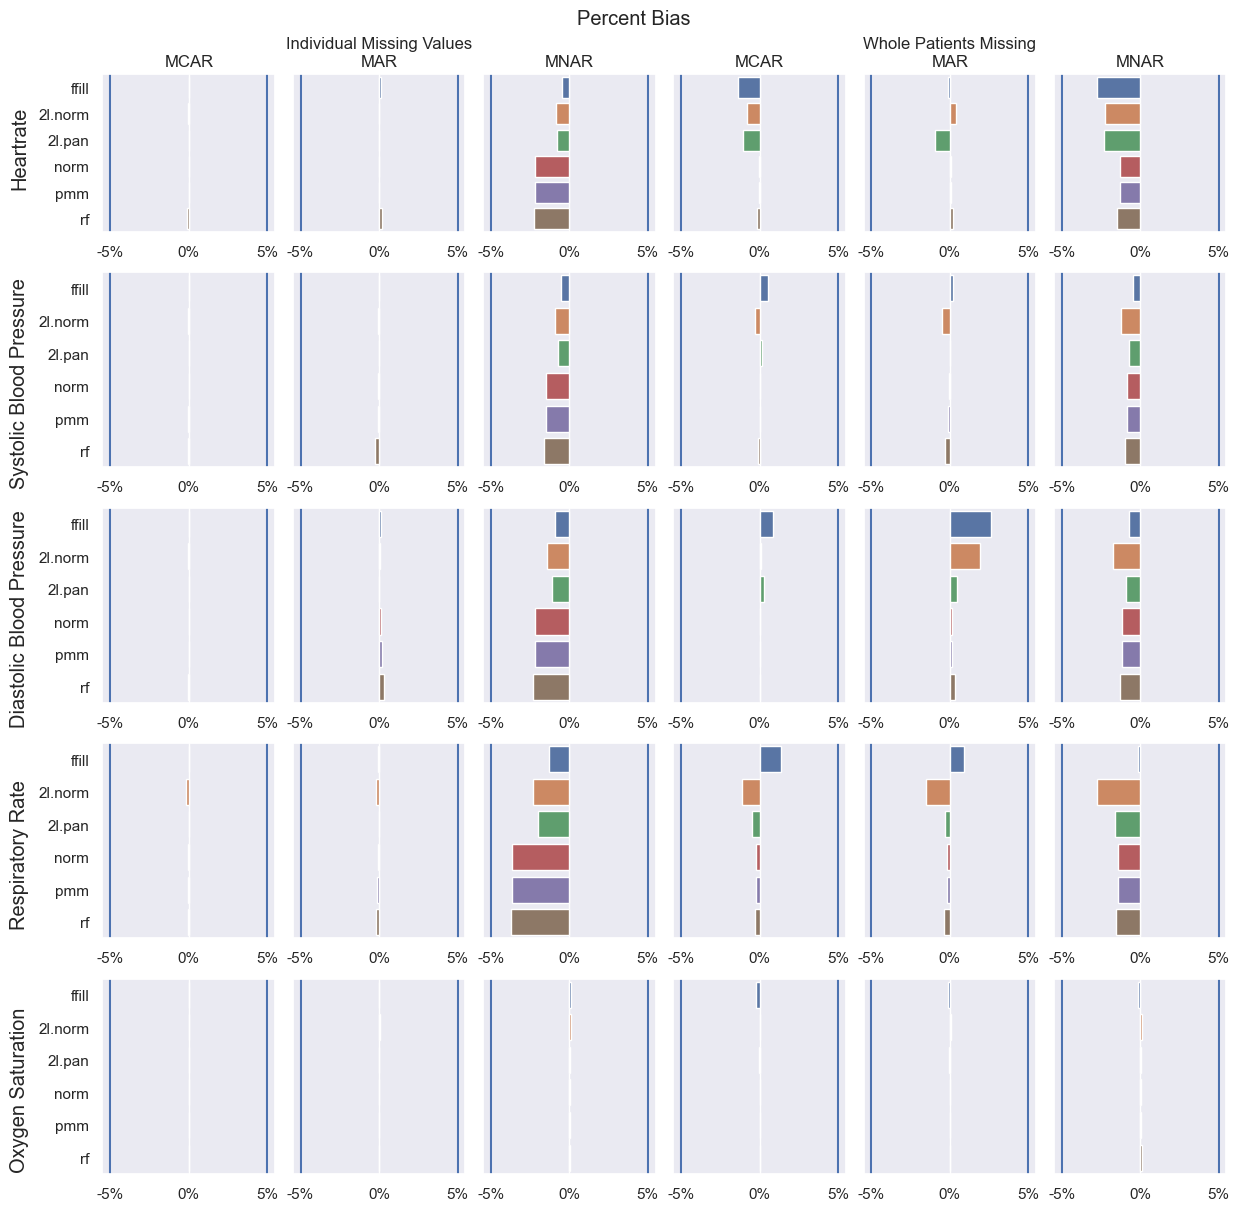

In [121]:
# all features

fig = plt.figure(constrained_layout=True, figsize=(12,12))
fig.suptitle('Percent Bias')


subf = fig.subfigures(5,1)


subf[0].suptitle('Heartrate' ,x=-0.02, y=0.5, ha='left', va='center', rotation=90)
hr = subf[0].subplots(1,6, sharex=False, sharey=True)

## mcar
sns.barplot(ax=hr[0], data=evaldf[(evaldf['miss_pattern']=='mcar') & (evaldf['miss_type']=='single')], y='method', x='perc_bias_hr', linewidth=1)
## mar
sns.barplot(ax=hr[1], data=evaldf[(evaldf['miss_pattern']=='mar')  & (evaldf['miss_type']=='single')], y='method', x='perc_bias_hr', linewidth=1)
## mnar
sns.barplot(ax=hr[2], data=evaldf[(evaldf['miss_pattern']=='mnar') & (evaldf['miss_type']=='single')], y='method', x='perc_bias_hr', linewidth=1)
## mcar
sns.barplot(ax=hr[3], data=evaldf[(evaldf['miss_pattern']=='mcar') & (evaldf['miss_type']=='patient')], y='method', x='perc_bias_hr', linewidth=1)
## mar
sns.barplot(ax=hr[4], data=evaldf[(evaldf['miss_pattern']=='mar')  & (evaldf['miss_type']=='patient')], y='method', x='perc_bias_hr', linewidth=1)
## mnar
sns.barplot(ax=hr[5], data=evaldf[(evaldf['miss_pattern']=='mnar') & (evaldf['miss_type']=='patient')], y='method', x='perc_bias_hr', linewidth=1)

pat = ['MCAR','Individual Missing Values\nMAR','MNAR','MCAR','Whole Patients Missing\nMAR','MNAR']

for p,t in zip(hr,pat):
    p.axvline(5)
    p.axvline(-5)
    p.set_title(t)
    p.set_xlabel('')
    p.set_ylabel('')
    p.set_xticklabels(['{:.0%}'.format(x/100) for x in p.get_xticks()])
    p.set_yticklabels(meth_labels)


subf[1].suptitle('Systolic Blood Pressure',x=-0.02, y=0.5, ha='left', va='center', rotation=90)
sbp = subf[1].subplots(1,6, sharex=False, sharey=True)

## mcar
sns.barplot(ax=sbp[0], data=evaldf[(evaldf['miss_pattern']=='mcar') & (evaldf['miss_type']=='single')], y='method', x='perc_bias_sbp', linewidth=1)
## mar
sns.barplot(ax=sbp[1], data=evaldf[(evaldf['miss_pattern']=='mar')  & (evaldf['miss_type']=='single')], y='method', x='perc_bias_sbp', linewidth=1)
## mnar
sns.barplot(ax=sbp[2], data=evaldf[(evaldf['miss_pattern']=='mnar') & (evaldf['miss_type']=='single')], y='method', x='perc_bias_sbp', linewidth=1)
## mcar
sns.barplot(ax=sbp[3], data=evaldf[(evaldf['miss_pattern']=='mcar') & (evaldf['miss_type']=='patient')], y='method', x='perc_bias_sbp', linewidth=1)
## mar
sns.barplot(ax=sbp[4], data=evaldf[(evaldf['miss_pattern']=='mar')  & (evaldf['miss_type']=='patient')], y='method', x='perc_bias_sbp', linewidth=1)
## mnar
sns.barplot(ax=sbp[5], data=evaldf[(evaldf['miss_pattern']=='mnar') & (evaldf['miss_type']=='patient')], y='method', x='perc_bias_sbp', linewidth=1)



for p,t in zip(sbp,pat):
    p.axvline(5)
    p.axvline(-5)
    p.set_xlabel('')
    p.set_ylabel('')
    p.set_xticklabels(['{:.0%}'.format(x/100) for x in p.get_xticks()])
    p.set_yticklabels(meth_labels)

subf[2].suptitle('Diastolic Blood Pressure',x=-0.02, y=0.5, ha='left', va='center', rotation=90)
dbp = subf[2].subplots(1,6, sharex=False, sharey=True)

## mcar
sns.barplot(ax=dbp[0], data=evaldf[(evaldf['miss_pattern']=='mcar') & (evaldf['miss_type']=='single')], y='method', x='perc_bias_dbp', linewidth=1)
## mar
sns.barplot(ax=dbp[1], data=evaldf[(evaldf['miss_pattern']=='mar')  & (evaldf['miss_type']=='single')], y='method', x='perc_bias_dbp', linewidth=1)
## mnar
sns.barplot(ax=dbp[2], data=evaldf[(evaldf['miss_pattern']=='mnar') & (evaldf['miss_type']=='single')], y='method', x='perc_bias_dbp', linewidth=1)
## mcar
sns.barplot(ax=dbp[3], data=evaldf[(evaldf['miss_pattern']=='mcar') & (evaldf['miss_type']=='patient')], y='method', x='perc_bias_dbp', linewidth=1)
## mar
sns.barplot(ax=dbp[4], data=evaldf[(evaldf['miss_pattern']=='mar')  & (evaldf['miss_type']=='patient')], y='method', x='perc_bias_dbp', linewidth=1)
## mnar
sns.barplot(ax=dbp[5], data=evaldf[(evaldf['miss_pattern']=='mnar') & (evaldf['miss_type']=='patient')], y='method', x='perc_bias_dbp', linewidth=1)


for p,t in zip(dbp,pat):
    p.axvline(5)
    p.axvline(-5)
    p.set_xlabel('')
    p.set_ylabel('')
    p.set_xticklabels(['{:.0%}'.format(x/100) for x in p.get_xticks()])
    p.set_yticklabels(meth_labels)


subf[3].suptitle('Respiratory Rate',x=-0.02, y=0.5, ha='left', va='center', rotation=90)
rr = subf[3].subplots(1,6, sharex=False, sharey=True)

## mcar
sns.barplot(ax=rr[0], data=evaldf[(evaldf['miss_pattern']=='mcar') & (evaldf['miss_type']=='single')], y='method', x='perc_bias_rr', linewidth=1)
## mar
sns.barplot(ax=rr[1], data=evaldf[(evaldf['miss_pattern']=='mar')  & (evaldf['miss_type']=='single')], y='method', x='perc_bias_rr', linewidth=1)
## mnar
sns.barplot(ax=rr[2], data=evaldf[(evaldf['miss_pattern']=='mnar') & (evaldf['miss_type']=='single')], y='method', x='perc_bias_rr', linewidth=1)
## mcar
sns.barplot(ax=rr[3], data=evaldf[(evaldf['miss_pattern']=='mcar') & (evaldf['miss_type']=='patient')], y='method', x='perc_bias_rr', linewidth=1)
## mar
sns.barplot(ax=rr[4], data=evaldf[(evaldf['miss_pattern']=='mar')  & (evaldf['miss_type']=='patient')], y='method', x='perc_bias_rr', linewidth=1)
## mnar
sns.barplot(ax=rr[5], data=evaldf[(evaldf['miss_pattern']=='mnar') & (evaldf['miss_type']=='patient')], y='method', x='perc_bias_rr', linewidth=1)


for p,t in zip(rr,pat):
    p.axvline(5)
    p.axvline(-5)
    p.set_xlabel('')
    p.set_ylabel('')
    p.set_xticklabels(['{:.0%}'.format(x/100) for x in p.get_xticks()])
    p.set_yticklabels(meth_labels)

subf[4].suptitle('Oxygen Saturation',x=-0.02, y=0.5, ha='left', va='center', rotation=90)
ox = subf[4].subplots(1,6, sharex=False, sharey=True)

## mcar
sns.barplot(ax=ox[0], data=evaldf[(evaldf['miss_pattern']=='mcar') & (evaldf['miss_type']=='single')], y='method', x='perc_bias_ox', linewidth=1)
## mar
sns.barplot(ax=ox[1], data=evaldf[(evaldf['miss_pattern']=='mar')  & (evaldf['miss_type']=='single')], y='method', x='perc_bias_ox', linewidth=1)
## mnar
sns.barplot(ax=ox[2], data=evaldf[(evaldf['miss_pattern']=='mnar') & (evaldf['miss_type']=='single')], y='method', x='perc_bias_ox', linewidth=1)
## mcar
sns.barplot(ax=ox[3], data=evaldf[(evaldf['miss_pattern']=='mcar') & (evaldf['miss_type']=='patient')], y='method', x='perc_bias_ox', linewidth=1)
## mar
sns.barplot(ax=ox[4], data=evaldf[(evaldf['miss_pattern']=='mar')  & (evaldf['miss_type']=='patient')], y='method', x='perc_bias_ox', linewidth=1)
## mnar
sns.barplot(ax=ox[5], data=evaldf[(evaldf['miss_pattern']=='mnar') & (evaldf['miss_type']=='patient')], y='method', x='perc_bias_ox', linewidth=1)

for p,t in zip(ox,pat):
    p.axvline(5)
    p.axvline(-5)
    p.set_xlabel('')
    p.set_ylabel('')
    p.set_xticklabels(['{:.0%}'.format(x/100) for x in p.get_xticks()])
    p.set_yticklabels(meth_labels)


# plt.savefig('outdata/images/eval/percentbias.pdf', bbox_inches='tight')  
plt.show()

### Coverage Rate

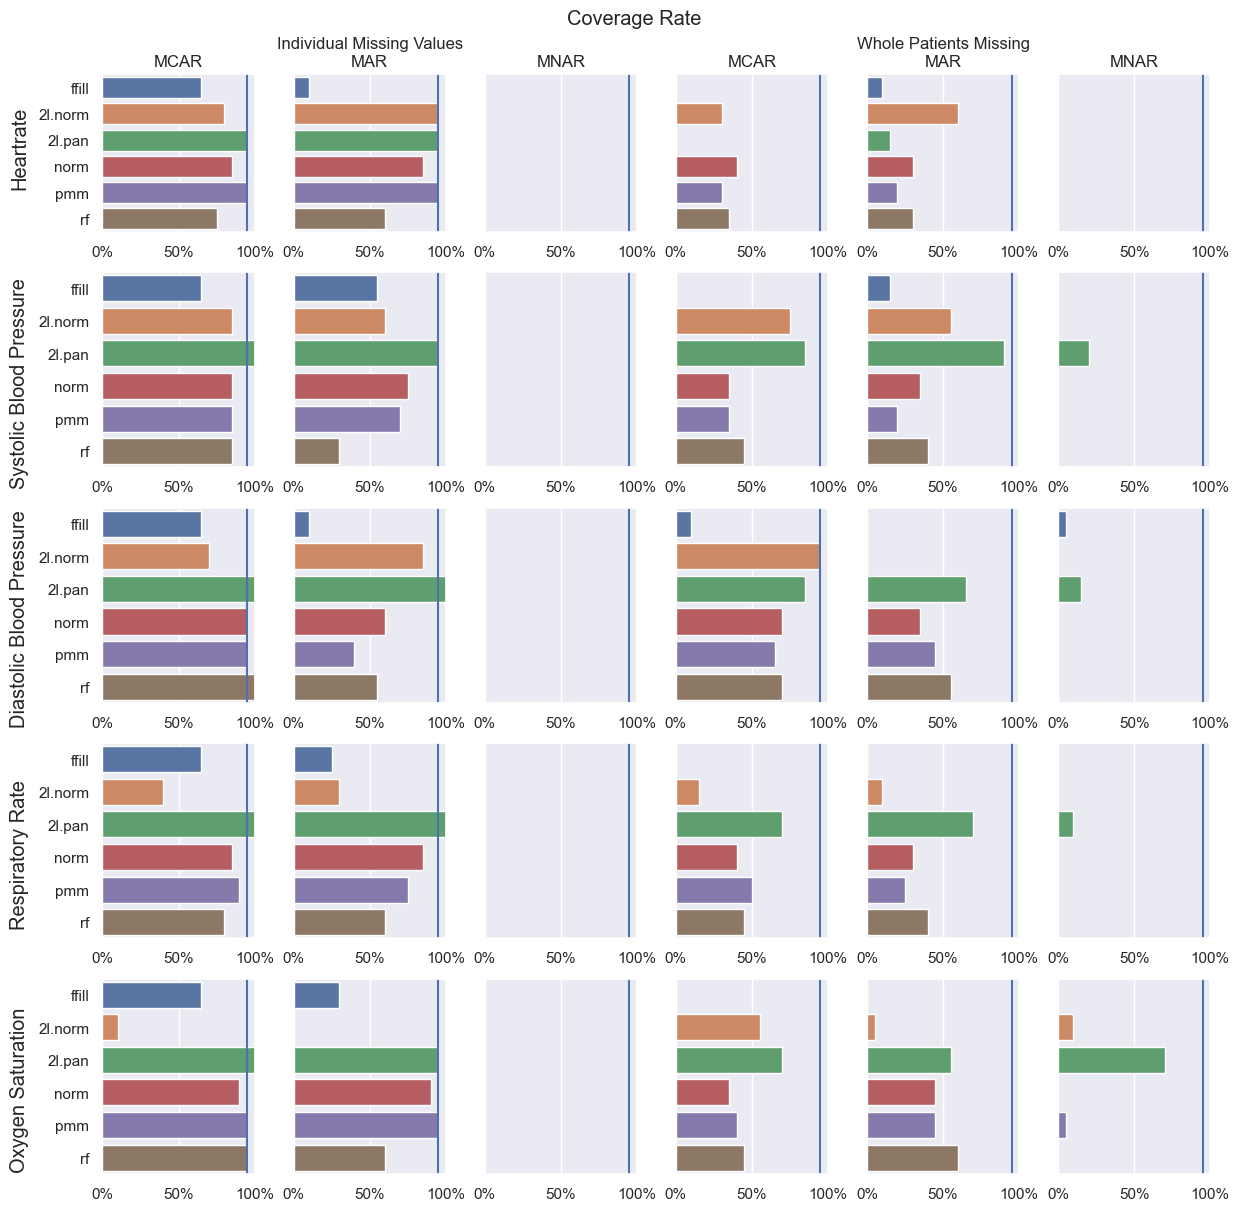

In [93]:
# all features

fig = plt.figure(constrained_layout=True, figsize=(12,12))
fig.suptitle('Coverage Rate')


subf = fig.subfigures(5,1)


subf[0].suptitle('Heartrate' ,x=-0.02, y=0.5, ha='left', va='center', rotation=90)
hr = subf[0].subplots(1,6, sharex=False, sharey=True)

## mcar
sns.barplot(ax=hr[0], data=evaldf[(evaldf['miss_pattern']=='mcar') & (evaldf['miss_type']=='single')], y='method', x='cov_hr', linewidth=1)
## mar
sns.barplot(ax=hr[1], data=evaldf[(evaldf['miss_pattern']=='mar')  & (evaldf['miss_type']=='single')], y='method', x='cov_hr', linewidth=1)
## mnar
sns.barplot(ax=hr[2], data=evaldf[(evaldf['miss_pattern']=='mnar') & (evaldf['miss_type']=='single')], y='method', x='cov_hr', linewidth=1)
## mcar
sns.barplot(ax=hr[3], data=evaldf[(evaldf['miss_pattern']=='mcar') & (evaldf['miss_type']=='patient')], y='method', x='cov_hr', linewidth=1)
## mar
sns.barplot(ax=hr[4], data=evaldf[(evaldf['miss_pattern']=='mar')  & (evaldf['miss_type']=='patient')], y='method', x='cov_hr', linewidth=1)
## mnar
sns.barplot(ax=hr[5], data=evaldf[(evaldf['miss_pattern']=='mnar') & (evaldf['miss_type']=='patient')], y='method', x='cov_hr', linewidth=1)

pat = ['MCAR','Individual Missing Values\nMAR','MNAR','MCAR','Whole Patients Missing\nMAR','MNAR']

for p,t in zip(hr,pat):
    p.axvline(.95)
    p.set_xlim(0,1)
    p.set_title(t)
    p.set_xlabel('')
    p.set_ylabel('')
    p.set_xticklabels(['{:.0%}'.format(x) for x in p.get_xticks()])
    p.set_yticklabels(meth_labels)


subf[1].suptitle('Systolic Blood Pressure',x=-0.02, y=0.5, ha='left', va='center', rotation=90)
sbp = subf[1].subplots(1,6, sharex=False, sharey=True)

## mcar
sns.barplot(ax=sbp[0], data=evaldf[(evaldf['miss_pattern']=='mcar') & (evaldf['miss_type']=='single')], y='method', x='cov_sbp', linewidth=1)
## mar
sns.barplot(ax=sbp[1], data=evaldf[(evaldf['miss_pattern']=='mar')  & (evaldf['miss_type']=='single')], y='method', x='cov_sbp', linewidth=1)
## mnar
sns.barplot(ax=sbp[2], data=evaldf[(evaldf['miss_pattern']=='mnar') & (evaldf['miss_type']=='single')], y='method', x='cov_sbp', linewidth=1)
## mcar
sns.barplot(ax=sbp[3], data=evaldf[(evaldf['miss_pattern']=='mcar') & (evaldf['miss_type']=='patient')], y='method', x='cov_sbp', linewidth=1)
## mar
sns.barplot(ax=sbp[4], data=evaldf[(evaldf['miss_pattern']=='mar')  & (evaldf['miss_type']=='patient')], y='method', x='cov_sbp', linewidth=1)
## mnar
sns.barplot(ax=sbp[5], data=evaldf[(evaldf['miss_pattern']=='mnar') & (evaldf['miss_type']=='patient')], y='method', x='cov_sbp', linewidth=1)



for p,t in zip(sbp,pat):
    p.axvline(.95)
    p.set_xlim(0,1)
    p.set_xlabel('')
    p.set_ylabel('')
    p.set_xticklabels(['{:.0%}'.format(x) for x in p.get_xticks()])
    p.set_yticklabels(meth_labels)

subf[2].suptitle('Diastolic Blood Pressure',x=-0.02, y=0.5, ha='left', va='center', rotation=90)
dbp = subf[2].subplots(1,6, sharex=False, sharey=True)

## mcar
sns.barplot(ax=dbp[0], data=evaldf[(evaldf['miss_pattern']=='mcar') & (evaldf['miss_type']=='single')], y='method', x='cov_dbp', linewidth=1)
## mar
sns.barplot(ax=dbp[1], data=evaldf[(evaldf['miss_pattern']=='mar')  & (evaldf['miss_type']=='single')], y='method', x='cov_dbp', linewidth=1)
## mnar
sns.barplot(ax=dbp[2], data=evaldf[(evaldf['miss_pattern']=='mnar') & (evaldf['miss_type']=='single')], y='method', x='cov_dbp', linewidth=1)
## mcar
sns.barplot(ax=dbp[3], data=evaldf[(evaldf['miss_pattern']=='mcar') & (evaldf['miss_type']=='patient')], y='method', x='cov_dbp', linewidth=1)
## mar
sns.barplot(ax=dbp[4], data=evaldf[(evaldf['miss_pattern']=='mar')  & (evaldf['miss_type']=='patient')], y='method', x='cov_dbp', linewidth=1)
## mnar
sns.barplot(ax=dbp[5], data=evaldf[(evaldf['miss_pattern']=='mnar') & (evaldf['miss_type']=='patient')], y='method', x='cov_dbp', linewidth=1)


for p,t in zip(dbp,pat):
    p.axvline(.95)
    p.set_xlim(0,1)
    p.set_xlabel('')
    p.set_ylabel('')
    p.set_xticklabels(['{:.0%}'.format(x) for x in p.get_xticks()])
    p.set_yticklabels(meth_labels)


subf[3].suptitle('Respiratory Rate',x=-0.02, y=0.5, ha='left', va='center', rotation=90)
rr = subf[3].subplots(1,6, sharex=False, sharey=True)

## mcar
sns.barplot(ax=rr[0], data=evaldf[(evaldf['miss_pattern']=='mcar') & (evaldf['miss_type']=='single')], y='method', x='cov_rr', linewidth=1)
## mar
sns.barplot(ax=rr[1], data=evaldf[(evaldf['miss_pattern']=='mar')  & (evaldf['miss_type']=='single')], y='method', x='cov_rr', linewidth=1)
## mnar
sns.barplot(ax=rr[2], data=evaldf[(evaldf['miss_pattern']=='mnar') & (evaldf['miss_type']=='single')], y='method', x='cov_rr', linewidth=1)
## mcar
sns.barplot(ax=rr[3], data=evaldf[(evaldf['miss_pattern']=='mcar') & (evaldf['miss_type']=='patient')], y='method', x='cov_rr', linewidth=1)
## mar
sns.barplot(ax=rr[4], data=evaldf[(evaldf['miss_pattern']=='mar')  & (evaldf['miss_type']=='patient')], y='method', x='cov_rr', linewidth=1)
## mnar
sns.barplot(ax=rr[5], data=evaldf[(evaldf['miss_pattern']=='mnar') & (evaldf['miss_type']=='patient')], y='method', x='cov_rr', linewidth=1)


for p,t in zip(rr,pat):
    p.axvline(.95)
    p.set_xlim(0,1)
    p.set_xlabel('')
    p.set_ylabel('')
    p.set_xticklabels(['{:.0%}'.format(x) for x in p.get_xticks()])
    p.set_yticklabels(meth_labels)

subf[4].suptitle('Oxygen Saturation',x=-0.02, y=0.5, ha='left', va='center', rotation=90)
ox = subf[4].subplots(1,6, sharex=False, sharey=True)

## mcar
sns.barplot(ax=ox[0], data=evaldf[(evaldf['miss_pattern']=='mcar') & (evaldf['miss_type']=='single')], y='method', x='cov_ox', linewidth=1)
## mar
sns.barplot(ax=ox[1], data=evaldf[(evaldf['miss_pattern']=='mar')  & (evaldf['miss_type']=='single')], y='method', x='cov_ox', linewidth=1)
## mnar
sns.barplot(ax=ox[2], data=evaldf[(evaldf['miss_pattern']=='mnar') & (evaldf['miss_type']=='single')], y='method', x='cov_ox', linewidth=1)
## mcar
sns.barplot(ax=ox[3], data=evaldf[(evaldf['miss_pattern']=='mcar') & (evaldf['miss_type']=='patient')], y='method', x='cov_ox', linewidth=1)
## mar
sns.barplot(ax=ox[4], data=evaldf[(evaldf['miss_pattern']=='mar')  & (evaldf['miss_type']=='patient')], y='method', x='cov_ox', linewidth=1)
## mnar
sns.barplot(ax=ox[5], data=evaldf[(evaldf['miss_pattern']=='mnar') & (evaldf['miss_type']=='patient')], y='method', x='cov_ox', linewidth=1)

for p,t in zip(ox,pat):
    p.axvline(.95)
    p.set_xlim(0,1)
    p.set_xlabel('')
    p.set_ylabel('')
    p.set_xticklabels(['{:.0%}'.format(x) for x in p.get_xticks()])
    p.set_yticklabels(meth_labels)


plt.savefig('outdata/images/eval/coveragerate.pdf', bbox_inches='tight')  
plt.show()

In [96]:
evaldf.head(1)

,method,miss_pattern,miss_type,perc_bias_hr,cov_hr,aw_hr,bias_hr,perc_bias_sbp,cov_sbp,aw_sbp,...,aw_dbp,bias_dbp,perc_bias_rr,cov_rr,aw_rr,bias_rr,perc_bias_ox,cov_ox,aw_ox,bias_ox
0,None_ffillMedian,mar,patient,-0.108222,0.1,0.067862,-0.091364,0.183074,0.15,0.085816,...,0.058337,1.647221,0.886781,0.0,0.021303,0.167873,-0.139193,0.0,0.01191,-0.134765


In [100]:
covcols = [col for col in evaldf.columns if 'cov' in col]
covcols

['cov_hr', 'cov_sbp', 'cov_dbp', 'cov_rr', 'cov_ox']

In [105]:
# Average coverage rate over all features
evaldf.groupby(['method', 'miss_type', 'miss_pattern'])[covcols].mean().mean(axis=1)

method            miss_type  miss_pattern
None_ffillMedian  patient    mar             0.05
                             mcar            0.02
                             mnar            0.01
                  single     mar             0.26
                             mcar            0.65
                             mnar            0.00
mice_2l.norm      patient    mar             0.26
                             mcar            0.54
                             mnar            0.02
                  single     mar             0.54
                             mcar            0.57
                             mnar            0.00
mice_2l.pan       patient    mar             0.59
                             mcar            0.62
                             mnar            0.23
                  single     mar             0.97
                             mcar            0.99
                             mnar            0.00
mice_norm         patient    mar             0.35
        

### Average Width

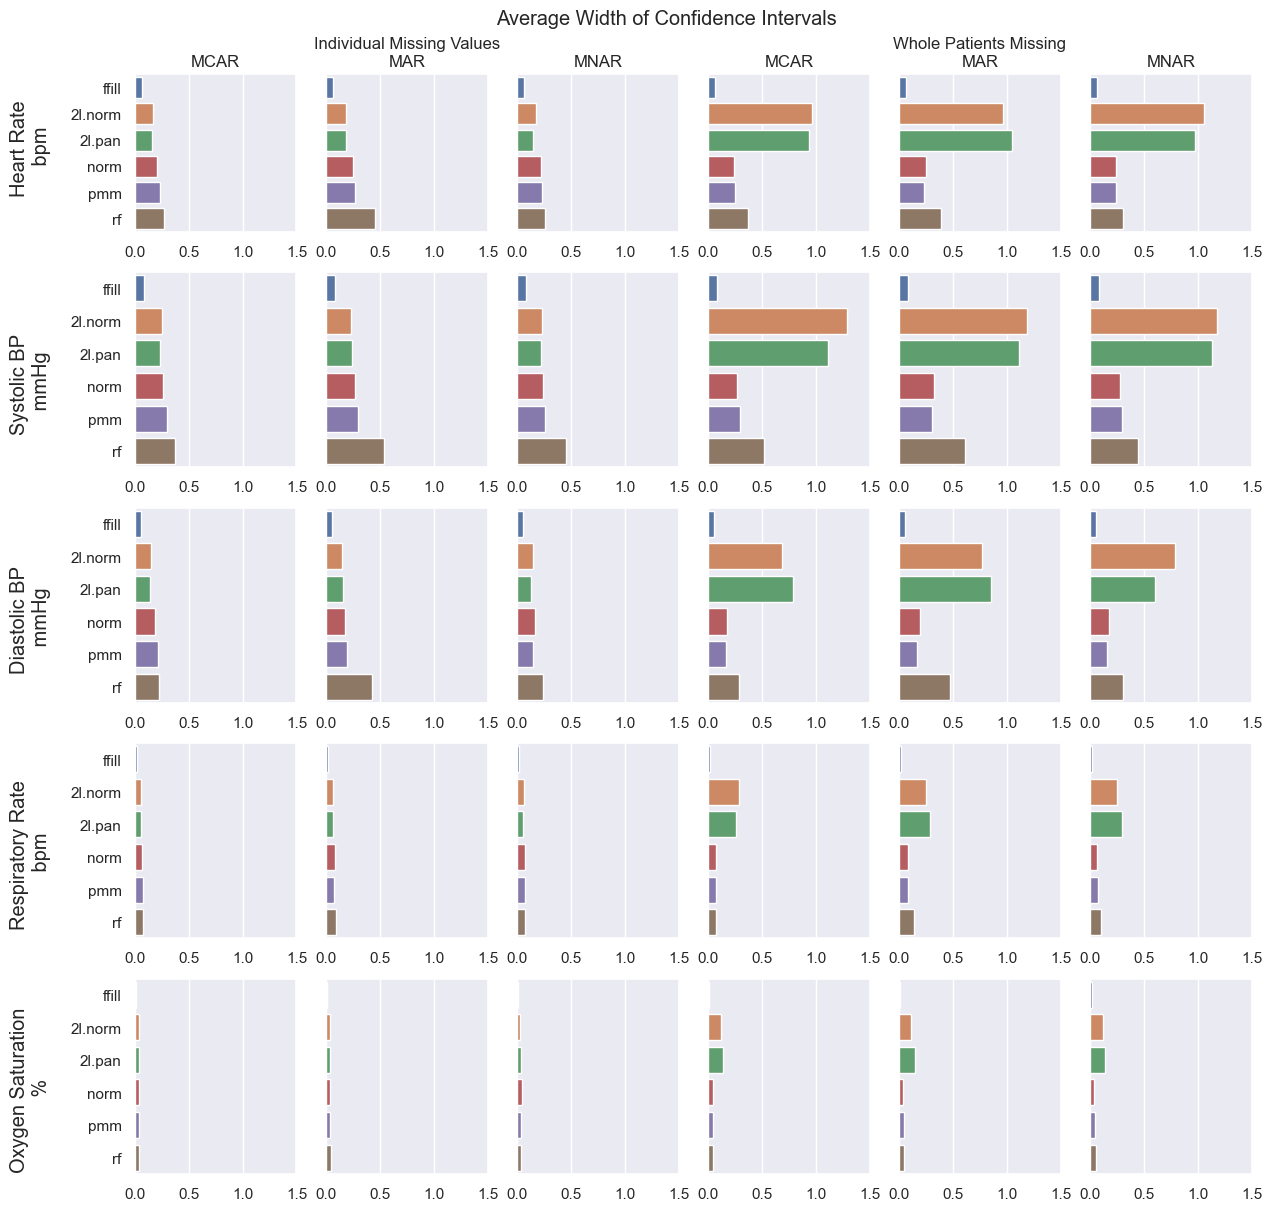

In [39]:
# all features

fig = plt.figure(constrained_layout=True, figsize=(12,12))
fig.suptitle('Average Width of Confidence Intervals')

titles = ['Heart Rate', 'Systolic BP', 'Diastolic BP', 'Respiratory Rate', 'Oxygen Saturation', ]
units = ['bpm', 'mmHg', 'mmHg', 'bpm', '%']
titlewithunit = [ title +"\n " + unit for title, unit in zip(titles, units)]
pat = ['MCAR','Individual Missing Values\nMAR','MNAR','MCAR','Whole Patients Missing\nMAR','MNAR']

subf = fig.subfigures(5,1)

hr = subf[0].subplots(1,6, sharex=True, sharey=True)
sbp = subf[1].subplots(1,6, sharex=True, sharey=True)
dbp = subf[2].subplots(1,6, sharex=True, sharey=True)
rr = subf[3].subplots(1,6, sharex=True, sharey=True)
ox = subf[4].subplots(1,6, sharex=True, sharey=True)

rows = [hr, sbp, dbp, rr, ox]

## Single
sns.barplot(ax=hr[0], data=evaldf[(evaldf['miss_pattern']=='mcar') & (evaldf['miss_type']=='single')], y='method', x='aw_hr', linewidth=1)## mcar
sns.barplot(ax=hr[1], data=evaldf[(evaldf['miss_pattern']=='mar')  & (evaldf['miss_type']=='single')], y='method', x='aw_hr', linewidth=1)## mar
sns.barplot(ax=hr[2], data=evaldf[(evaldf['miss_pattern']=='mnar') & (evaldf['miss_type']=='single')], y='method', x='aw_hr', linewidth=1)## mnar
## Patient
sns.barplot(ax=hr[3], data=evaldf[(evaldf['miss_pattern']=='mcar') & (evaldf['miss_type']=='patient')], y='method', x='aw_hr', linewidth=1)## mcar
sns.barplot(ax=hr[4], data=evaldf[(evaldf['miss_pattern']=='mar')  & (evaldf['miss_type']=='patient')], y='method', x='aw_hr', linewidth=1)## mar
sns.barplot(ax=hr[5], data=evaldf[(evaldf['miss_pattern']=='mnar') & (evaldf['miss_type']=='patient')], y='method', x='aw_hr', linewidth=1)## mnar

## Single
sns.barplot(ax=sbp[0], data=evaldf[(evaldf['miss_pattern']=='mcar') & (evaldf['miss_type']=='single')], y='method', x='aw_sbp', linewidth=1)## mcar
sns.barplot(ax=sbp[1], data=evaldf[(evaldf['miss_pattern']=='mar')  & (evaldf['miss_type']=='single')], y='method', x='aw_sbp', linewidth=1)## mar
sns.barplot(ax=sbp[2], data=evaldf[(evaldf['miss_pattern']=='mnar') & (evaldf['miss_type']=='single')], y='method', x='aw_sbp', linewidth=1)## mnar
sns.barplot(ax=sbp[3], data=evaldf[(evaldf['miss_pattern']=='mcar') & (evaldf['miss_type']=='patient')], y='method', x='aw_sbp', linewidth=1)## mcar
sns.barplot(ax=sbp[4], data=evaldf[(evaldf['miss_pattern']=='mar')  & (evaldf['miss_type']=='patient')], y='method', x='aw_sbp', linewidth=1)## mar
sns.barplot(ax=sbp[5], data=evaldf[(evaldf['miss_pattern']=='mnar') & (evaldf['miss_type']=='patient')], y='method', x='aw_sbp', linewidth=1)## mnar

## Single
sns.barplot(ax=dbp[0], data=evaldf[(evaldf['miss_pattern']=='mcar') & (evaldf['miss_type']=='single')], y='method', x='aw_dbp', linewidth=1)## mcar
sns.barplot(ax=dbp[1], data=evaldf[(evaldf['miss_pattern']=='mar')  & (evaldf['miss_type']=='single')], y='method', x='aw_dbp', linewidth=1)## mar
sns.barplot(ax=dbp[2], data=evaldf[(evaldf['miss_pattern']=='mnar') & (evaldf['miss_type']=='single')], y='method', x='aw_dbp', linewidth=1)## mnar
sns.barplot(ax=dbp[3], data=evaldf[(evaldf['miss_pattern']=='mcar') & (evaldf['miss_type']=='patient')], y='method', x='aw_dbp', linewidth=1)## mcar
sns.barplot(ax=dbp[4], data=evaldf[(evaldf['miss_pattern']=='mar')  & (evaldf['miss_type']=='patient')], y='method', x='aw_dbp', linewidth=1)## mar
sns.barplot(ax=dbp[5], data=evaldf[(evaldf['miss_pattern']=='mnar') & (evaldf['miss_type']=='patient')], y='method', x='aw_dbp', linewidth=1)## mnar

## Single
sns.barplot(ax=rr[0], data=evaldf[(evaldf['miss_pattern']=='mcar') & (evaldf['miss_type']=='single')], y='method', x='aw_rr', linewidth=1)## mcar
sns.barplot(ax=rr[1], data=evaldf[(evaldf['miss_pattern']=='mar')  & (evaldf['miss_type']=='single')], y='method', x='aw_rr', linewidth=1)## mar
sns.barplot(ax=rr[2], data=evaldf[(evaldf['miss_pattern']=='mnar') & (evaldf['miss_type']=='single')], y='method', x='aw_rr', linewidth=1)## mnar
sns.barplot(ax=rr[3], data=evaldf[(evaldf['miss_pattern']=='mcar') & (evaldf['miss_type']=='patient')], y='method', x='aw_rr', linewidth=1)## mcar
sns.barplot(ax=rr[4], data=evaldf[(evaldf['miss_pattern']=='mar')  & (evaldf['miss_type']=='patient')], y='method', x='aw_rr', linewidth=1)## mar
sns.barplot(ax=rr[5], data=evaldf[(evaldf['miss_pattern']=='mnar') & (evaldf['miss_type']=='patient')], y='method', x='aw_rr', linewidth=1)## mnar

## Single
sns.barplot(ax=ox[0], data=evaldf[(evaldf['miss_pattern']=='mcar') & (evaldf['miss_type']=='single')], y='method', x='aw_ox', linewidth=1)## mcar
sns.barplot(ax=ox[1], data=evaldf[(evaldf['miss_pattern']=='mar')  & (evaldf['miss_type']=='single')], y='method', x='aw_ox', linewidth=1)## mar
sns.barplot(ax=ox[2], data=evaldf[(evaldf['miss_pattern']=='mnar') & (evaldf['miss_type']=='single')], y='method', x='aw_ox', linewidth=1)## mnar
sns.barplot(ax=ox[3], data=evaldf[(evaldf['miss_pattern']=='mcar') & (evaldf['miss_type']=='patient')], y='method', x='aw_ox', linewidth=1)## mcar
sns.barplot(ax=ox[4], data=evaldf[(evaldf['miss_pattern']=='mar')  & (evaldf['miss_type']=='patient')], y='method', x='aw_ox', linewidth=1)## mar
sns.barplot(ax=ox[5], data=evaldf[(evaldf['miss_pattern']=='mnar') & (evaldf['miss_type']=='patient')], y='method', x='aw_ox', linewidth=1)## mnar

# rowtitles - features
for i in range(5):
    subf[i].suptitle(titlewithunit[i],x=-0.03, y=0.5, ha='center', va='center', rotation=90)

# coltitles - missingness scenario
for i in range(6):
    hr[i].set_title(pat[i])

for row in rows:
    for p in row:
        p.set_xlabel('')
        p.set_ylabel('')
        p.set_xlim(0, 1.5)
        p.set_yticklabels(meth_labels)


plt.savefig('outdata/images/eval/averagewidth.pdf', bbox_inches='tight')  
plt.show()